In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.aparent_large_all_libs import load_saved_predictor


Using TensorFlow backend.


<h2>Define Cleavage Loss Function and SeqProp Wrapper</h2>

- Define a cleavage loss function generator, maximizing cuts at the target position.<br/>
- Build a SeqProp wrapper that builds the generator and predictor, and executs the optimization.<br/>


In [15]:

#Define target cleavage loss function
def get_cleavage_loss(cut_pos, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, punish_dn_cse=0.0, punish_up_c=0.0, reward_dn_ggcc=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_cuts = np.zeros((1, 1, 206))
    target_cuts[:, :, cut_pos] = 1.0
    
    use_entropy_mse = get_target_entropy_sme(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    dse_entropy_mse = get_target_entropy_sme(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=20, pwm_end=70)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=125)
    
    punish_dn_gg_func = get_punish_gg(pwm_start=80, pwm_end=110)
    punish_dn_cc_func = get_punish_cc(pwm_start=80, pwm_end=110)
    
    punish_up_aa_func = get_punish_aa(pwm_start=20, pwm_end=70)
    punish_dn_aa_func = get_punish_aa(pwm_start=76, pwm_end=125)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred = predictor_outputs

        #Create target cut constant
        cut_true = K.tile(K.constant(target_cuts), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        cut_loss = 1.0 * K.mean(kl_divergence(cut_true, cut_pred), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        
        seq_loss += reward_dn_ggcc * (-1.) * K.mean(punish_dn_gg_func(pwm) * punish_dn_cc_func(pwm), axis=0)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = cut_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, init_sequences, p_init, target_cuts, loss_funcs, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        target_cut = target_cuts[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], init_sequences=init_sequences[obj_ix], p_init=p_init, batch_normalize_pwm=True)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context='simple'), n_sequences=n_sequences, n_samples=n_samples, eval_mode='sample')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=70, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist())
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts



In [16]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)

<h2>Run SeqProp to Maximize Cleavage (Hardcoded AT objective)</h2>

- Generate 2 PWMs for 2 target cut positions (4 sequence in total).<br/>
- Auxiliary objectives: Punish upstream C, reward packing Gs and Cs in stretches.<br/>
- Hard-code an AT dinucleotide at the target cut position, restricting poly-A buildup.<br/>
<br/>
- <b>p_init (Initial sequence nt probabilities) = 0.995</b><br/>


Running optimization experiment 'Hardcoded AT'
Optimizing objective 0...


/home/jlinder2/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
5000/5000 [==============================] - 110s 22ms/step - loss: 1.1701


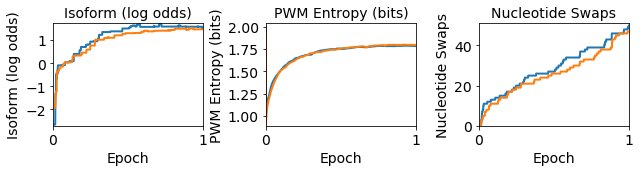

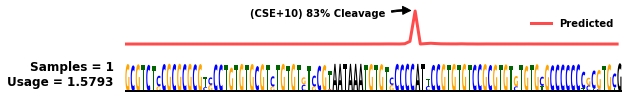

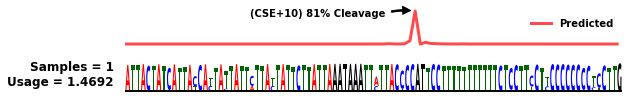

Optimizing objective 1...


/home/jlinder2/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
5000/5000 [==============================] - 103s 21ms/step - loss: 1.7469


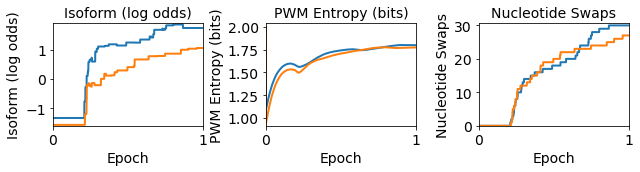

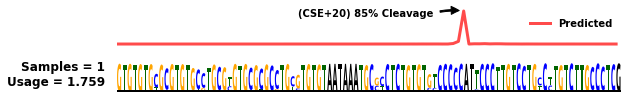

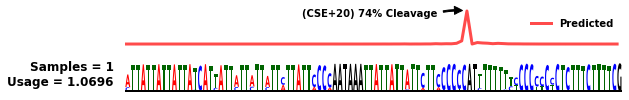

In [18]:
#Run SeqProp Optimization (experiment 'Hardcoded AT')

print("Running optimization experiment 'Hardcoded AT'")

#Number of PWMs to generate per objective
n_sequences = 2
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 5
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 5000

#Define sequence templates for each objectve
sequence_templates = [
    'TTCTTCATGCATGTGATTTTGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TTCTTCATGCATGTGATTTTGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

#Define list of target cleavage positions (one per objective)
cut_objectives = [
    86,
    96
]

#Define list of loss functions (one per objective)
losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=25,
        use_end=70,
        use_target_bits=1.8,
        cse_start=70,
        cse_end=76,
        cse_target_bits=1.9,
        dse_start=76,
        dse_end=125,
        dse_target_bits=1.8,
        entropy_weight=1.0,
        punish_dn_cse=1.0,
        punish_up_c=0.005,
        reward_dn_ggcc=0.0,
        punish_up_aa=0.001,
        punish_dn_aa=0.0
    ) for cut_pos in cut_objectives
]

#Define list of initial sequences (one list per objective)
init_sequences = [
    [
        'XXXXXXXXXXXXXXXXXXXXXXXXXTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTXXXXXXTGTGTGTGTGXXTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'XXXXXXXXXXXXXXXXXXXXXXXXXTTATTATTATTATTATTATTATTATTATTATTATTATTATTATTAXXXXXXTTATTATTATXXTATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    ],
    [
        'XXXXXXXXXXXXXXXXXXXXXXXXXTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTXXXXXXTGTGTGTGTGTGTGTGTGTGXXTGTCTTGTCTTGTCTTGTCTTGTCTTTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'XXXXXXXXXXXXXXXXXXXXXXXXXTTATTATTATTATTATTATTATTATTATTATTATTATTATTATTAXXXXXXTTATTATTATTATTATTATTXXTTTTTTTTTTTTTTTTTTTTTTTTTTTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    ]
]

p_init = 0.995

hardcoded_at_pwms, hardcoded_at_cuts = run_seqprop(sequence_templates, init_sequences, p_init, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


<h2>Run SeqProp to Maximize Cleavage (Hardcoded AT objective)</h2>

- Generate 2 PWMs for 2 target cut positions (4 sequence in total).<br/>
- Auxiliary objectives: Punish upstream C, reward packing Gs and Cs in stretches.<br/>
- Hard-code an AT dinucleotide at the target cut position, restricting poly-A buildup.<br/>
<br/>
- <b>p_init (Initial sequence nt probabilities) = 0.4</b><br/>


Running optimization experiment 'Hardcoded AT'
Optimizing objective 0...


/home/jlinder2/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
5000/5000 [==============================] - 101s 20ms/step - loss: 0.8391


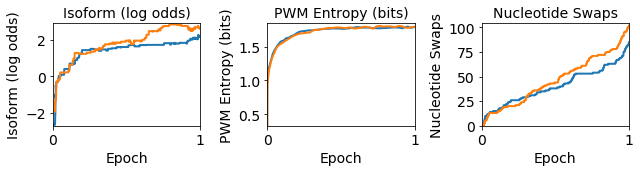

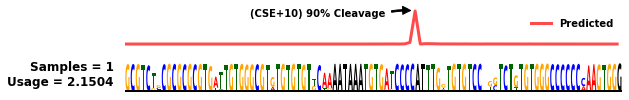

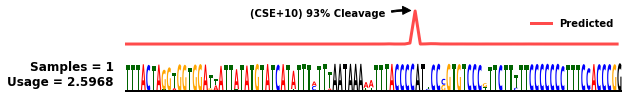

Optimizing objective 1...


/home/jlinder2/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
5000/5000 [==============================] - 104s 21ms/step - loss: 0.6314


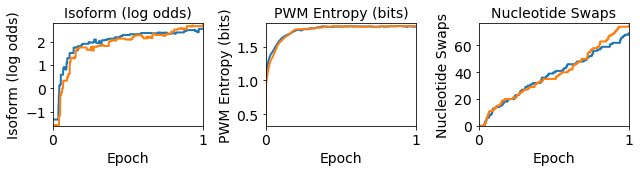

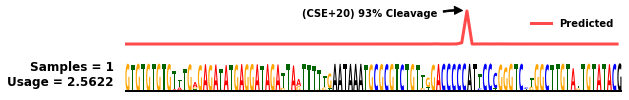

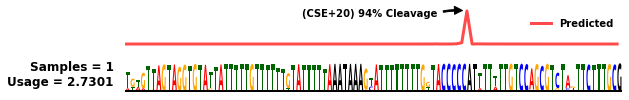

In [19]:
#Run SeqProp Optimization (experiment 'Hardcoded AT')

print("Running optimization experiment 'Hardcoded AT'")

#Number of PWMs to generate per objective
n_sequences = 2
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 5
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 5000

#Define sequence templates for each objectve
sequence_templates = [
    'TTCTTCATGCATGTGATTTTGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TTCTTCATGCATGTGATTTTGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

#Define list of target cleavage positions (one per objective)
cut_objectives = [
    86,
    96
]

#Define list of loss functions (one per objective)
losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=25,
        use_end=70,
        use_target_bits=1.8,
        cse_start=70,
        cse_end=76,
        cse_target_bits=1.9,
        dse_start=76,
        dse_end=125,
        dse_target_bits=1.8,
        entropy_weight=1.0,
        punish_dn_cse=1.0,
        punish_up_c=0.005,
        reward_dn_ggcc=0.0,
        punish_up_aa=0.001,
        punish_dn_aa=0.0
    ) for cut_pos in cut_objectives
]

#Define list of initial sequences (one list per objective)
init_sequences = [
    [
        'XXXXXXXXXXXXXXXXXXXXXXXXXTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTXXXXXXTGTGTGTGTGXXTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'XXXXXXXXXXXXXXXXXXXXXXXXXTTATTATTATTATTATTATTATTATTATTATTATTATTATTATTAXXXXXXTTATTATTATXXTATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    ],
    [
        'XXXXXXXXXXXXXXXXXXXXXXXXXTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTXXXXXXTGTGTGTGTGTGTGTGTGTGXXTGTCTTGTCTTGTCTTGTCTTGTCTTTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
        'XXXXXXXXXXXXXXXXXXXXXXXXXTTATTATTATTATTATTATTATTATTATTATTATTATTATTATTAXXXXXXTTATTATTATTATTATTATTXXTTTTTTTTTTTTTTTTTTTTTTTTTTTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    ]
]

p_init = 0.4

hardcoded_at_pwms, hardcoded_at_cuts = run_seqprop(sequence_templates, init_sequences, p_init, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)
